In [84]:
# ===============================
# Librairies
# ===============================
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import copy

import ta
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [85]:
# ===============================
# Load a real time series
# ===============================
def load_data_from_csv(filepath):
    # Load CSV without header
    df = pd.read_csv(filepath, header=None)
    # Combine first two rows into a single header
    header1 = df.iloc[0].fillna("")  # market symbols
    header2 = df.iloc[1].fillna("")  # OHLCV etc
    # Create new column names
    new_header = []
    for h1, h2 in zip(header1, header2):
        if h1 != "":
            new_header.append(f"{h1}_{h2}" if h2 != "" else h1)
        else:
            new_header.append(h2)
    # Drop first two rows from the data
    df = df[2:]
    df.columns = new_header
    df = df.reset_index(drop=True)
    # Optional: remove fully empty columns
    df = df.dropna(axis=1, how='all')
    return df

df_load = load_data_from_csv("../data/Stock_Market_Initial_Data.csv")
df_load

/var/folders/8j/y46wyjvx641clg_t_cq0ggfc0000gn/T/ipykernel_81606/4198978970.py:6: DtypeWarning: Columns (1,2,3,4,5,6,8,9,10,11,12,13,15,16,17,18,19,20,22,23,24,25,26,27,29,30,31,32,33,34,36,37,38,39,40,41,43,44,45,46,47,48,50,51,52,53,54,55,57,58,59,60,61,62,64,65,66,67,68,69,71,72,73,74,75,76,78,79,80,81,82,83,85,86,87,88,89,90,92,93,94,95,96,97,99,100,101,102,103,104,106,107,108,109,110,111,113,114,115,116,117,118,120,121,122,123,124,125,127,128,129,130,131,132,134,135,136,137,138,139,141,142,143,144,145,146,148,149,150,151,152,153,155,156,157,158,159,160,162,163,164,165,166,167,169,170,171,172,173,174,176,177,178,179,180,181,183,184,185,186,187,188,190,191,192,193,194,195,197,198,199,200,201,202,204,205,206,207,208,209,211,212,213,214,215,216,218,219,220,221,222,223,225,226,227,228,229,230) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, header=None)


,Date,^GSPC_High,Low,Open,Close,Volume,Adj Close,^IXIC_High,Low,Open,...,Open,Close,Volume,Adj Close,^JN0U.JO_High,Low,Open,Close,Volume,Adj Close
0,12/31/1996,753.9500122,740.7399902,753.8499756,740.7399902,399760000,740.7399902,1291.880005,1285.449951,1289.23999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1/2/1997,742.8099976,729.5499878,740.7399902,737.0100098,463230000,737.0100098,1293.630005,1272.339966,1292.650024,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1/3/1997,748.2399902,737.0100098,737.0100098,748.0300293,452970000,748.0300293,1310.839966,1280.699951,1288.02002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1/6/1997,753.3099976,743.8200073,748.0300293,747.6500244,531350000,747.6500244,1321.469971,1310.630005,1314.339966,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1/7/1997,753.2600098,742.1799927,747.6500244,753.2299805,538220000,753.2299805,1327.819946,1312.079956,1316.910034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6504,11/2/2022,3894.439941,3758.679932,3852.899902,3759.689941,4899000000,3759.689941,10993.24023,10522.90039,10885.00977,...,NaN,NaN,NaN,NaN,3640.830078,3566.639893,3602.090088,3573.790039,0.0,3573.790039
6505,11/3/2022,3750.590088,3698.149902,3733.25,3719.889893,4625290000,3719.889893,10486.00977,10319.54004,10399.4502,...,NaN,NaN,NaN,NaN,3557.22998,3431.080078,3557.0,3474.129883,0.0,3474.129883
6506,11/4/2022,3796.340088,3708.840088,3766.97998,3770.550049,0,3770.550049,10553.62988,10262.92969,10548.13965,...,NaN,NaN,NaN,NaN,3765.290039,3497.070068,3498.77002,3751.629883,0.0,3751.629883
6507,11/7/2022,3813.949951,3764.699951,3780.709961,3806.800049,4341620000,3806.800049,10587.95996,10428.91016,10516.94043,...,NaN,NaN,NaN,NaN,3826.070068,3695.27002,3749.379883,3815.75,0.0,3815.75


In [86]:
# ===============================
# Function to extract market data for a specific index from the CSV file
# ===============================
def extract_market_data(df, market_name):
    """
    Extract Date + OHLCV columns for a given market
    """
    df.columns = df.columns.str.strip()
    high_col_candidates = [c for c in df.columns if c.startswith(f"{market_name}_High")]
    if not high_col_candidates:
        raise ValueError(f"Column starting with {market_name}_High not found.")
    
    high_col = high_col_candidates[0]
    high_idx = df.columns.get_loc(high_col)
    
    # Date + next 6 columns (High, Low, Open, Close, Volume, Adj Close)
    cols_idx = [0] + list(range(high_idx, high_idx + 6))
    df_market = df.iloc[:, cols_idx].copy()
    df_market = df_market.reset_index(drop=True)
    
    # Rename columns for clarity
    df_market.columns = ["Date", "High", "Low", "Open", "Close", "Volume", "Adj Close"]
    df_market[["High", "Low", "Open", "Close", "Volume", "Adj Close"]] = df_market[["High", "Low", "Open", "Close", "Volume", "Adj Close"]].astype(float)
    return df_market

# Example for ^GSPC
df_gspc = extract_market_data(df_load, "^GSPC")
df_gspc

,Date,High,Low,Open,Close,Volume,Adj Close
0,12/31/1996,753.950012,740.739990,753.849976,740.739990,3.997600e+08,740.739990
1,1/2/1997,742.809998,729.549988,740.739990,737.010010,4.632300e+08,737.010010
2,1/3/1997,748.239990,737.010010,737.010010,748.030029,4.529700e+08,748.030029
3,1/6/1997,753.309998,743.820007,748.030029,747.650024,5.313500e+08,747.650024
4,1/7/1997,753.260010,742.179993,747.650024,753.229981,5.382200e+08,753.229981
...,...,...,...,...,...,...,...
6504,11/2/2022,3894.439941,3758.679932,3852.899902,3759.689941,4.899000e+09,3759.689941
6505,11/3/2022,3750.590088,3698.149902,3733.250000,3719.889893,4.625290e+09,3719.889893
6506,11/4/2022,3796.340088,3708.840088,3766.979980,3770.550049,0.000000e+00,3770.550049
6507,11/7/2022,3813.949951,3764.699951,3780.709961,3806.800049,4.341620e+09,3806.800049


In [87]:
# ===============================
# ta prepro
# ===============================
def add_technical_indicators(df):
    """
    Adds some sample technical indicators using the `ta` library (window periods and indicators can be adjusted)
    """
    # RSI
    df['rsi'] = ta.momentum.rsi(df['Close'], window=14)
    # Bollinger Bands
    bollinger = ta.volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)
    df['bb_high'] = bollinger.bollinger_hband()
    df['bb_low'] = bollinger.bollinger_lband()
    # Moving Average Slope
    df['ma_20'] = df['Close'].rolling(window=20).mean()
    df['ma_20_slope'] = df['ma_20'].diff()

    # Fill any NaNs from indicator calculations
    df.fillna(method='bfill', inplace=True)
    df.fillna(method='ffill', inplace=True)
    return df


def select_and_scale_features(df, feature_cols=None):
    """
    Given a DataFrame, selects the relevant columns and applies scaling
    Returns the scaled array, the fitted scaler (for inversing later), and the list of columns used
    """
    if feature_cols is None:
        # default feature set: OHLC and a few indicators
        feature_cols = ['Open', 'High', 'Low', 'Close', 'rsi', 'bb_high', 'bb_low', 'ma_20', 'ma_20_slope']

    data = df[feature_cols].values  # shape: (num_samples, num_features)
    scaler = RobustScaler()
    data_scaled = scaler.fit_transform(data)
    return data_scaled, scaler, feature_cols


# Example for ^GSPC
df_gspc = extract_market_data(df_load, "^GSPC")

# Add indicators
df = add_technical_indicators(df_gspc)

# Select features and scale
data_scaled, scaler, feature_cols = select_and_scale_features(df)
target_col_idx = feature_cols.index('Close')

/var/folders/8j/y46wyjvx641clg_t_cq0ggfc0000gn/T/ipykernel_81606/2694199180.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/var/folders/8j/y46wyjvx641clg_t_cq0ggfc0000gn/T/ipykernel_81606/2694199180.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [88]:
# ===============================
# Some hyperparameters for model training 
# ===============================
SEQ_LEN = 60           # input window (days)
PRED_HORIZON = 1       # predict 1 step ahead (next day), for multi-step, see recursive forecast
BATCH_SIZE = 64
EPOCHS = 10
VAL_SIZE = 0.1         # fraction for validation (time split used below)
TEST_SIZE = 0.1        # fraction for test (time split used below)

In [89]:
# ===============================
# Build sequences
# ===============================
class SeqDataset(Dataset):
    def __init__(self, data, seq_length=60, prediction_length=1, feature_dim=4, target_column_idx=0):
        """
        data: numpy array of shape [num_samples, num_features]
        seq_length: how many timesteps in the input sequence
        prediction_length: how many future steps we want to predict
        feature_dim: total number of features in data (for dimension checking)
        target_column_idx: which column to use as the target (e.g., close=0)
        """
        self.data = data
        self.seq_length = seq_length
        self.pred_length = prediction_length
        self.feature_dim = feature_dim
        self.target_column_idx = target_column_idx

    def __len__(self):
        # The maximum starting index is total_length - seq_length - prediction_length
        return len(self.data) - self.seq_length - self.pred_length + 1

    def __getitem__(self, idx):
        # Input sequence
        x = self.data[idx : idx + self.seq_length]
        # Future price(s)
        y = self.data[idx + self.seq_length : idx + self.seq_length + self.pred_length, self.target_column_idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    
    
dataset = SeqDataset(data_scaled, SEQ_LEN, PRED_HORIZON, len(feature_cols), target_col_idx)

In [90]:
# ===============================
# Train/validation (time-ordered)
# ===============================
# Train/Validation/Test Split
train_size = int(len(dataset) * (1 - VAL_SIZE - TEST_SIZE))
val_size = int(len(dataset) * VAL_SIZE)
test_size = len(dataset) - train_size - val_size

# Perform sequential splitting (without shuffling)
train_dataset = torch.utils.data.Subset(dataset, range(0, train_size))
val_dataset = torch.utils.data.Subset(dataset, range(train_size, train_size + val_size))
test_dataset = torch.utils.data.Subset(dataset, range(train_size + val_size, len(dataset)))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [91]:
# ===============================
# Model definition
# ===============================
# [Input: (B, SEQ_LEN, N_FEATURES)]
#          |
#      [Linear: N_FEATURES --> 64]
#          |
# [+Positional Embedding (1, SEQ_LEN, 64)]
#          |
#      [Transformer Encoder]
#      (2 Layers, 8 Heads, FF=256)
#          |
# [Output Linear: 64 --> 1]
#          |
# [Predictions: (B, PRED_HORIZON)]


class TimeSeriesTransformer(nn.Module):
    def __init__(self,
        feature_size=9,
        num_layers=2,
        d_model=64,
        nhead=8,
        dim_feedforward=256,
        dropout=0.1,
        seq_length=30,
        prediction_length=1
    ):
        super(TimeSeriesTransformer, self).__init__()

        # We'll embed each feature vector (feature_size) into a d_model-sized vector
        self.input_fc = nn.Linear(feature_size, d_model)

        # Positional Encoding (simple learnable or sinusoidal): learnable here:
        self.pos_embedding = nn.Parameter(torch.zeros(1, seq_length, d_model))

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation="relu", 
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Final output: we want to forecast `prediction_length` steps for 1 dimension (Close price)
        # (adjust for multi-step and multi-dimensional ...)
        self.fc_out = nn.Linear(d_model, prediction_length)

    def forward(self, src):
        """
        src shape: [batch_size, seq_length, feature_size]
        """
        
        batch_size, seq_len, _ = src.shape
        if seq_len > self.pos_embedding.size(1):
            raise RuntimeError(
                f"seq_len={seq_len} exceeds max positional length={self.pos_embedding.size(1)}"
            )


        # First project features into d_model
        src = self.input_fc(src)  # -> [batch_size, seq_length, d_model]

        # Add positional embedding
        # pos_embedding -> [1, seq_length, d_model], so broadcast along batch dimension
        src = src + self.pos_embedding[:, :seq_len, :]

        # Pass through the transformer
        encoded = self.transformer_encoder(src)  # [batch_size, seq_length, d_model]

        # We only want the output at the last time step for forecasting the future
        last_step = encoded[: , -1, :]  # [batch_size, d_model]

        out = self.fc_out(last_step)  # [batch_size, prediction_length]
        return out
    

model = TimeSeriesTransformer(
    feature_size=len(feature_cols),
    num_layers=2,
    d_model=64,
    nhead=8,
    dim_feedforward=256,
    dropout=0.1,
    seq_length=SEQ_LEN,
    prediction_length=PRED_HORIZON
)
device = torch.device("cpu")
torch.set_num_threads(1)   # extra safety on macOS

In [92]:
print(model)

TimeSeriesTransformer(
  (input_fc): Linear(in_features=9, out_features=64, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc_out): Linear(in_features=64, out_features=1, bias=True)
)


In [93]:
# ===============================
# Training
# ===============================
def train_model(
    model, device,
    train_loader, val_loader,
    epochs=10, learning_rate=1e-3, patience=5,
    max_grad_norm=1.0, scheduler_step=10, scheduler_gamma=0.5,
    print_every=1, verbose=True
):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

    model = model.to(device)

    best_val_loss = float("inf")
    best_model_state = copy.deepcopy(model.state_dict())
    patience_counter = 0

    history = {
        "train_loss": [],
        "val_loss": [],
        "lr": []
    }

    for epoch in range(1, epochs + 1):

        # Training
        model.train()
        train_losses = []

        for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Train]", leave=False):
            x_batch = x_batch.float().to(device)
            y_batch = y_batch.float().to(device)

            optimizer.zero_grad()

            output = model(x_batch)
            loss = criterion(output, y_batch)

            # NaN / Inf guard
            if not torch.isfinite(loss):
                print("Skipping batch due to NaN/Inf loss")
                continue

            loss.backward()

            # Gradient clipping (VERY important for Transformers)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()
            train_losses.append(loss.item())

        mean_train_loss = np.mean(train_losses)

        # Validation
        model.eval()
        val_losses = []

        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = x_val.float().to(device)
                y_val = y_val.float().to(device)

                output_val = model(x_val)
                loss_val = criterion(output_val, y_val)

                if torch.isfinite(loss_val):
                    val_losses.append(loss_val.item())

        mean_val_loss = np.mean(val_losses)

        # Scheduler
        scheduler.step()

        # Logging
        history["train_loss"].append(mean_train_loss)
        history["val_loss"].append(mean_val_loss)
        history["lr"].append(optimizer.param_groups[0]["lr"])

        if verbose and epoch % print_every == 0:
            print(f"Epoch [{epoch}/{epochs}] | Train: {mean_train_loss:.6f} | Val: {mean_val_loss:.6f} | LR: {optimizer.param_groups[0]['lr']:.2e}")

        # Early stopping 
        if mean_val_loss < best_val_loss:
            best_val_loss = mean_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch} (best val loss: {best_val_loss:.6f})")
            break

    # Restore best model
    model.load_state_dict(best_model_state)
    return model, history

In [94]:
trained_model, history = train_model(
    model=model, device=device,
    train_loader=train_loader, val_loader=val_loader,
    epochs=EPOCHS, learning_rate=1e-3, patience=5,
    max_grad_norm=1.0, scheduler_step=10, scheduler_gamma=0.5,
    print_every=1, verbose=True
)

Epoch [1/10] | Train: 0.172017 | Val: 0.121840 | LR: 1.00e-03


Epoch [2/10] | Train: 0.081351 | Val: 0.106841 | LR: 1.00e-03


Epoch [3/10] | Train: 0.011817 | Val: 0.112654 | LR: 1.00e-03


Epoch [4/10] | Train: 0.013955 | Val: 0.070344 | LR: 1.00e-03


Epoch [5/10] | Train: 0.009477 | Val: 0.137804 | LR: 1.00e-03


Epoch [6/10] | Train: 0.007304 | Val: 0.105726 | LR: 1.00e-03


Epoch [7/10] | Train: 0.008778 | Val: 0.112420 | LR: 1.00e-03


Epoch [8/10] | Train: 0.016718 | Val: 0.142939 | LR: 1.00e-03


Epoch [9/10] | Train: 0.037971 | Val: 0.174862 | LR: 1.00e-03

Early stopping triggered at epoch 9 (best val loss: 0.070344)


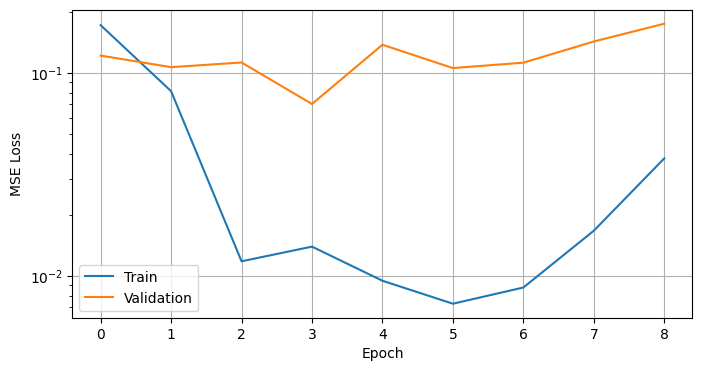

In [95]:
# ===============================
# Plot training loss & metrics
# ===============================
plt.figure(figsize=(8, 4))
plt.plot(history["train_loss"], label="Train")
plt.plot(history["val_loss"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

In [96]:
# ===============================
# Evaluate / Predictions (test)
# ===============================
# Predict (scaled)
def predict_model(model, dataloader, device, scaler, feature_cols, target_col_idx, pred_length):
    model.eval()
    all_preds = []
    all_trues = []
    n_features = len(feature_cols)

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.float().to(device)
            y_batch = y_batch.float().to(device)

            # Model output: (B, pred_length)
            preds = model(x_batch)
            preds = preds.cpu().numpy()
            trues = y_batch.cpu().numpy()
            B = preds.shape[0]

            # Vectorized inverse scaling
            dummy_pred = np.zeros((B * pred_length, n_features))
            dummy_true = np.zeros((B * pred_length, n_features))

            dummy_pred[:, target_col_idx] = preds.reshape(-1)
            dummy_true[:, target_col_idx] = trues.reshape(-1)

            inv_pred = scaler.inverse_transform(dummy_pred)[:, target_col_idx]
            inv_true = scaler.inverse_transform(dummy_true)[:, target_col_idx]

            all_preds.append(inv_pred)
            all_trues.append(inv_true)

    predicted_prices = np.concatenate(all_preds)
    real_prices = np.concatenate(all_trues)

    return real_prices, predicted_prices


real_test, pred_test = predict_model(
    model=trained_model,
    dataloader=test_loader,
    device=device,
    scaler=scaler,
    feature_cols=feature_cols,
    target_col_idx=target_col_idx,
    pred_length=PRED_HORIZON
)

In [97]:
# ===============================
# Evaluate / Predictions (compute metrics)
# ===============================
def compute_metrics(true, pred):
    true = np.asarray(true).reshape(-1)
    pred = np.asarray(pred).reshape(-1)

    mae = np.mean(np.abs(true - pred))
    mse = np.mean((true - pred) ** 2)
    rmse = np.sqrt(mse)

    return {"MAE": mae, "MSE": mse, "RMSE": rmse}


metrics_test = compute_metrics(real_test, pred_test) # (on original units)
print("Test metrics:", metrics_test)

Test metrics: {'MAE': 1171.0453201886523, 'MSE': 1557010.389190462, 'RMSE': 1247.8022235877215}


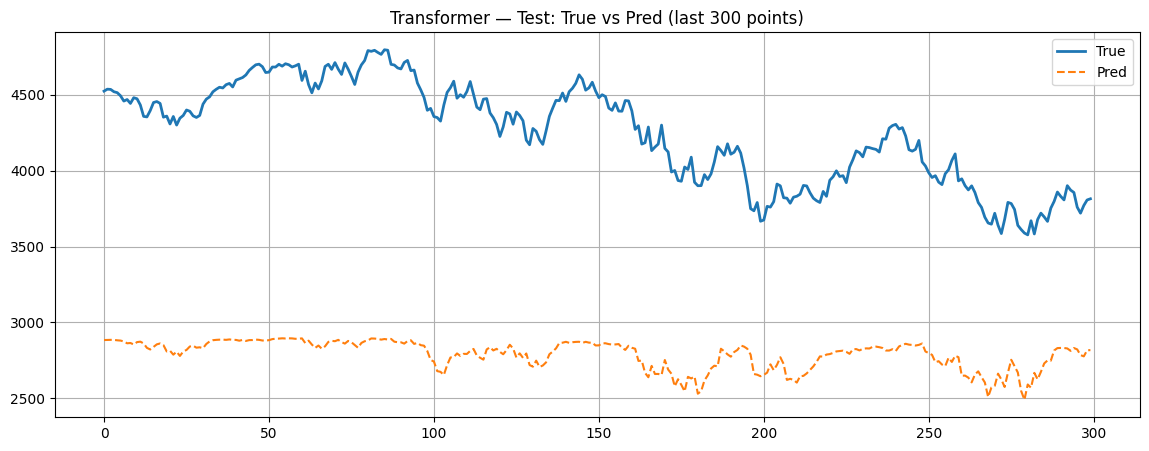

In [98]:
# ===============================
# Plot predictions vs true prices
# ===============================
Nplot = min(300, len(real_test))

plt.figure(figsize=(14, 5))
plt.plot(real_test[-Nplot:], label="True", linewidth=2)
plt.plot(pred_test[-Nplot:], label="Pred", linestyle="--")
plt.legend()
plt.grid(True)
plt.title(f"Transformer — Test: True vs Pred (last {Nplot} points)")
plt.show()

Train size: [ 773.87999343  757.11998683  759.64000204 ... 2500.600116   2502.22002251
 2496.65987789]


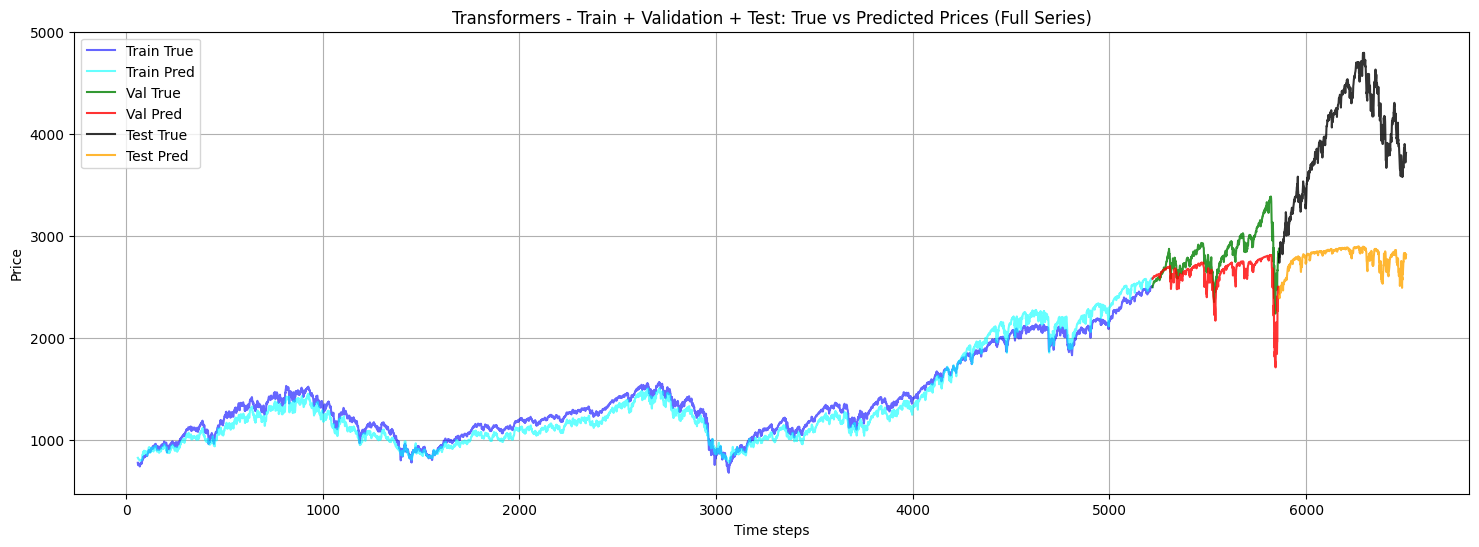

Training metrics (original units): {'MAE': 81.21367907861716, 'MSE': 7785.553423064503, 'RMSE': 88.23578312150067}
Validation metrics (original units): {'MAE': 196.03998068628266, 'MSE': 59535.69606599714, 'RMSE': 243.99937718362548}
Test metrics (original units): {'MAE': 1171.0453201886523, 'MSE': 1557010.389190462, 'RMSE': 1247.8022235877215}


In [99]:
# ===============================
# Full series plot - Train + Validation + Test
# ===============================
# Predict scaled values for train and validation
real_train, pred_train = predict_model(
    model=trained_model,
    dataloader=train_loader,
    device=device,
    scaler=scaler,
    feature_cols=feature_cols,
    target_col_idx=target_col_idx,
    pred_length=PRED_HORIZON
)
real_val, pred_val = predict_model(
    model=trained_model,
    dataloader=val_loader,
    device=device,
    scaler=scaler,
    feature_cols=feature_cols,
    target_col_idx=target_col_idx,
    pred_length=PRED_HORIZON
)

print("Train size:", real_train)

train_offset = SEQ_LEN
val_offset   = SEQ_LEN + len(real_train)
test_offset  = SEQ_LEN + len(real_train) + len(real_val)

# Plot the full series
plt.figure(figsize=(18,6))
plt.plot(range(train_offset, train_offset+len(real_train)), real_train, label="Train True", color='blue', alpha=0.6)
plt.plot(range(train_offset, train_offset+len(real_train)), pred_train, label="Train Pred", color='cyan', alpha=0.6)
plt.plot(range(val_offset, val_offset+len(real_val)), real_val, label="Val True", color='green', alpha=0.8)
plt.plot(range(val_offset, val_offset+len(real_val)), pred_val, label="Val Pred", color='red', alpha=0.8)
plt.plot(range(test_offset, test_offset+len(real_test)), real_test, label="Test True", color='black', alpha=0.8)
plt.plot(range(test_offset, test_offset+len(real_test)), pred_test, label="Test Pred", color='orange', alpha=0.8)
plt.xlabel("Time steps")
plt.ylabel("Price")
plt.title("Transformers - Train + Validation + Test: True vs Predicted Prices (Full Series)")
plt.legend()
plt.grid(True)
plt.show()

# Compute metrics (on original units)
def compute_metrics(true, pred):
    true = np.array(true).reshape(-1)
    pred = np.array(pred).reshape(-1)
    mae = np.mean(np.abs(true - pred))
    mse = np.mean((true - pred)**2)
    rmse_v = np.sqrt(mse)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse_v}

metrics_train = compute_metrics(real_train, pred_train)
metrics_val = compute_metrics(real_val, pred_val)
metrics_test = compute_metrics(real_test, pred_test)

print("Training metrics (original units):", metrics_train)
print("Validation metrics (original units):", metrics_val)
print("Test metrics (original units):", metrics_test)